In [1]:
import pandas as pd
from statsmodels.api import tsa
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import ds_tools as dst

In [2]:
wks_df = pd.read_pickle('data/LCL_unstack_wks.pkl')
wks_df.head()

tariff           Std       ToU
DateTime                      
2012-01-01  0.523669  0.528838
2012-01-08  0.540989  0.541720
2012-01-15  0.532780  0.526268
2012-01-22  0.550542  0.533956
2012-01-29  0.553962  0.503050

In [3]:
# recall DF_dict
DF_dict = pd.read_pickle('data/DF_dict.pkl')

In [4]:
decomp_periods = [8760, 365, 52]
for i in range(len(DF_dict['DF'])):
    df = DF_dict['DF'][i]
    suf = DF_dict['period'][i]
    period = decomp_periods[i]
    globals()['decomps' + suf] = dst.decompose_DFs(df, 'multiplicative', period)

For the ARIMA model, we will consider the weekly values as this has the least seasonality. The hourly and daily granularities will also likely exceed the computing resources available.

In [5]:
prds = ['Trend', 'Seasonal', 'Residual']

fig = make_subplots(rows=3, cols=1, subplot_titles=prds, shared_xaxes=False)

for i in range(len(prds)):
    prd = prds[i]
    df = decomps_wks

    fig.add_trace(                          # Plot standard tariff
        go.Line(
            x=df.index, y=df.iloc[:,i], 
            name = 'Standard', 
            line_color = '#F2A74B',
            legendgroup = prd
            ),
        row = i+1,
        col = 1,
    )

    fig.add_trace(                          # Plot variable tariff
        go.Line(
            x=df.index, y=df.iloc[:,i+3], 
            name = 'Variable',
            line_color = '#415885',
            legendgroup = prd
            ),
        row = i+1,
        col = 1
    )

    fig.update_xaxes(title_text='Date-Time', row=i+1, col=1)
    fig.update_yaxes(title_text='Multiplier', row=i+1, col=1)

    fig.update_layout(
        legend_title = "Tariff", 
        title = "Seasonal Decomposition of Weekly Average Power Consumption",
        legend_tracegroupgap=350,
        height= 1200
    )

fig.show()

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




---
## Standard Tariff

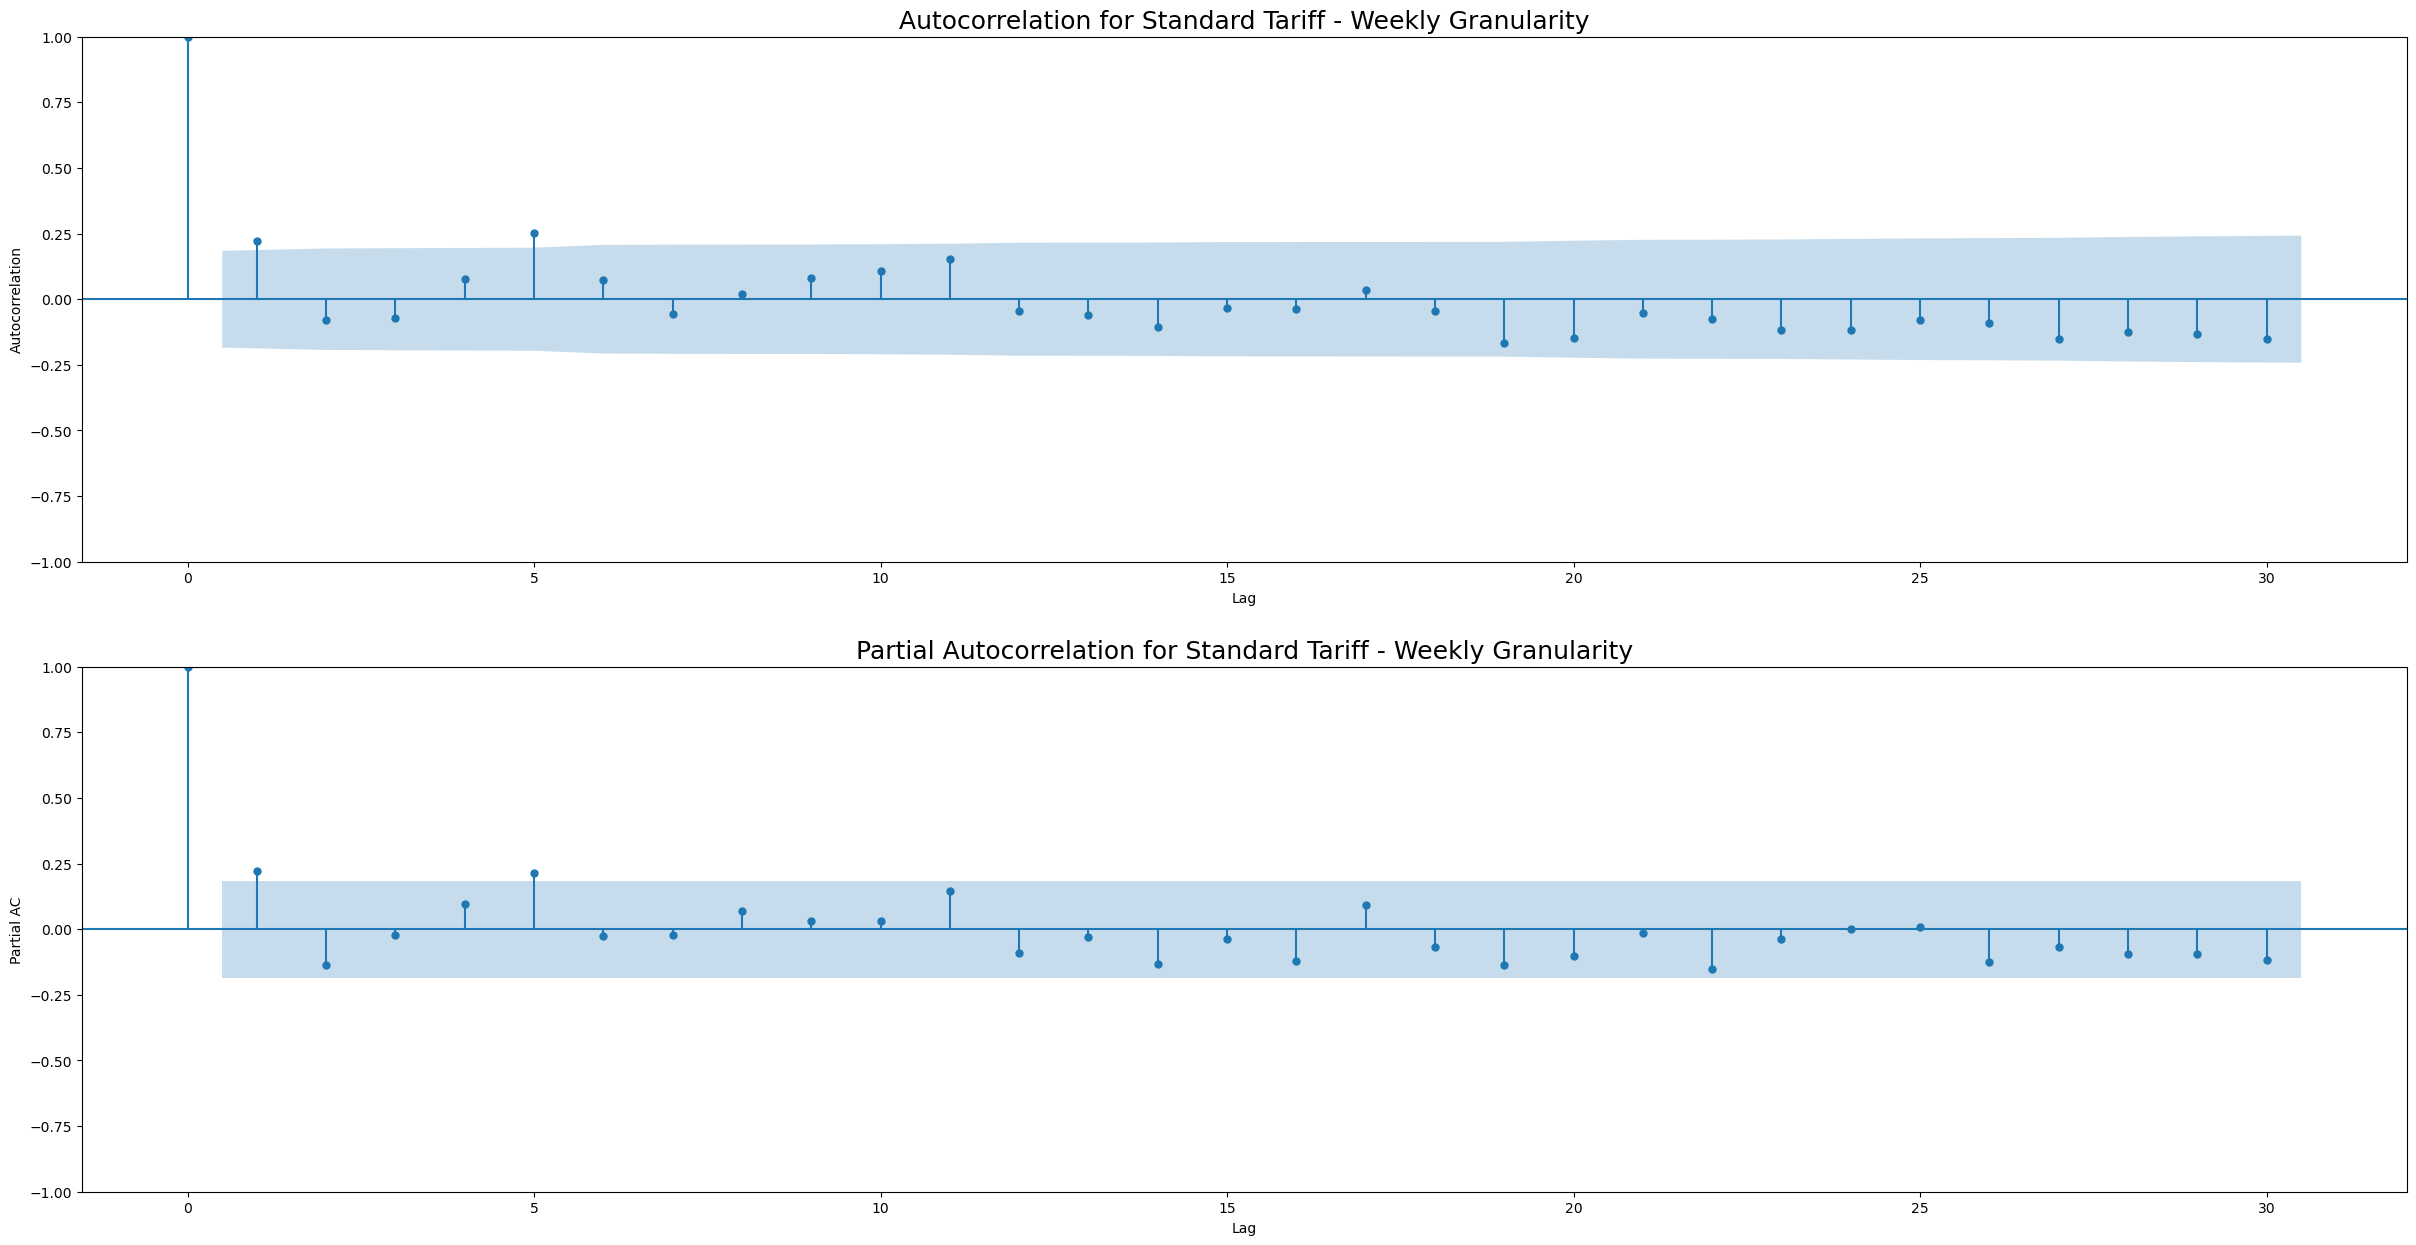

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(wks_df["Std"].diff(1).dropna(), lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Standard Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(wks_df["Std"].diff(1).dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Standard Tariff - Weekly Granularity', fontsize = 18)
plt.show()

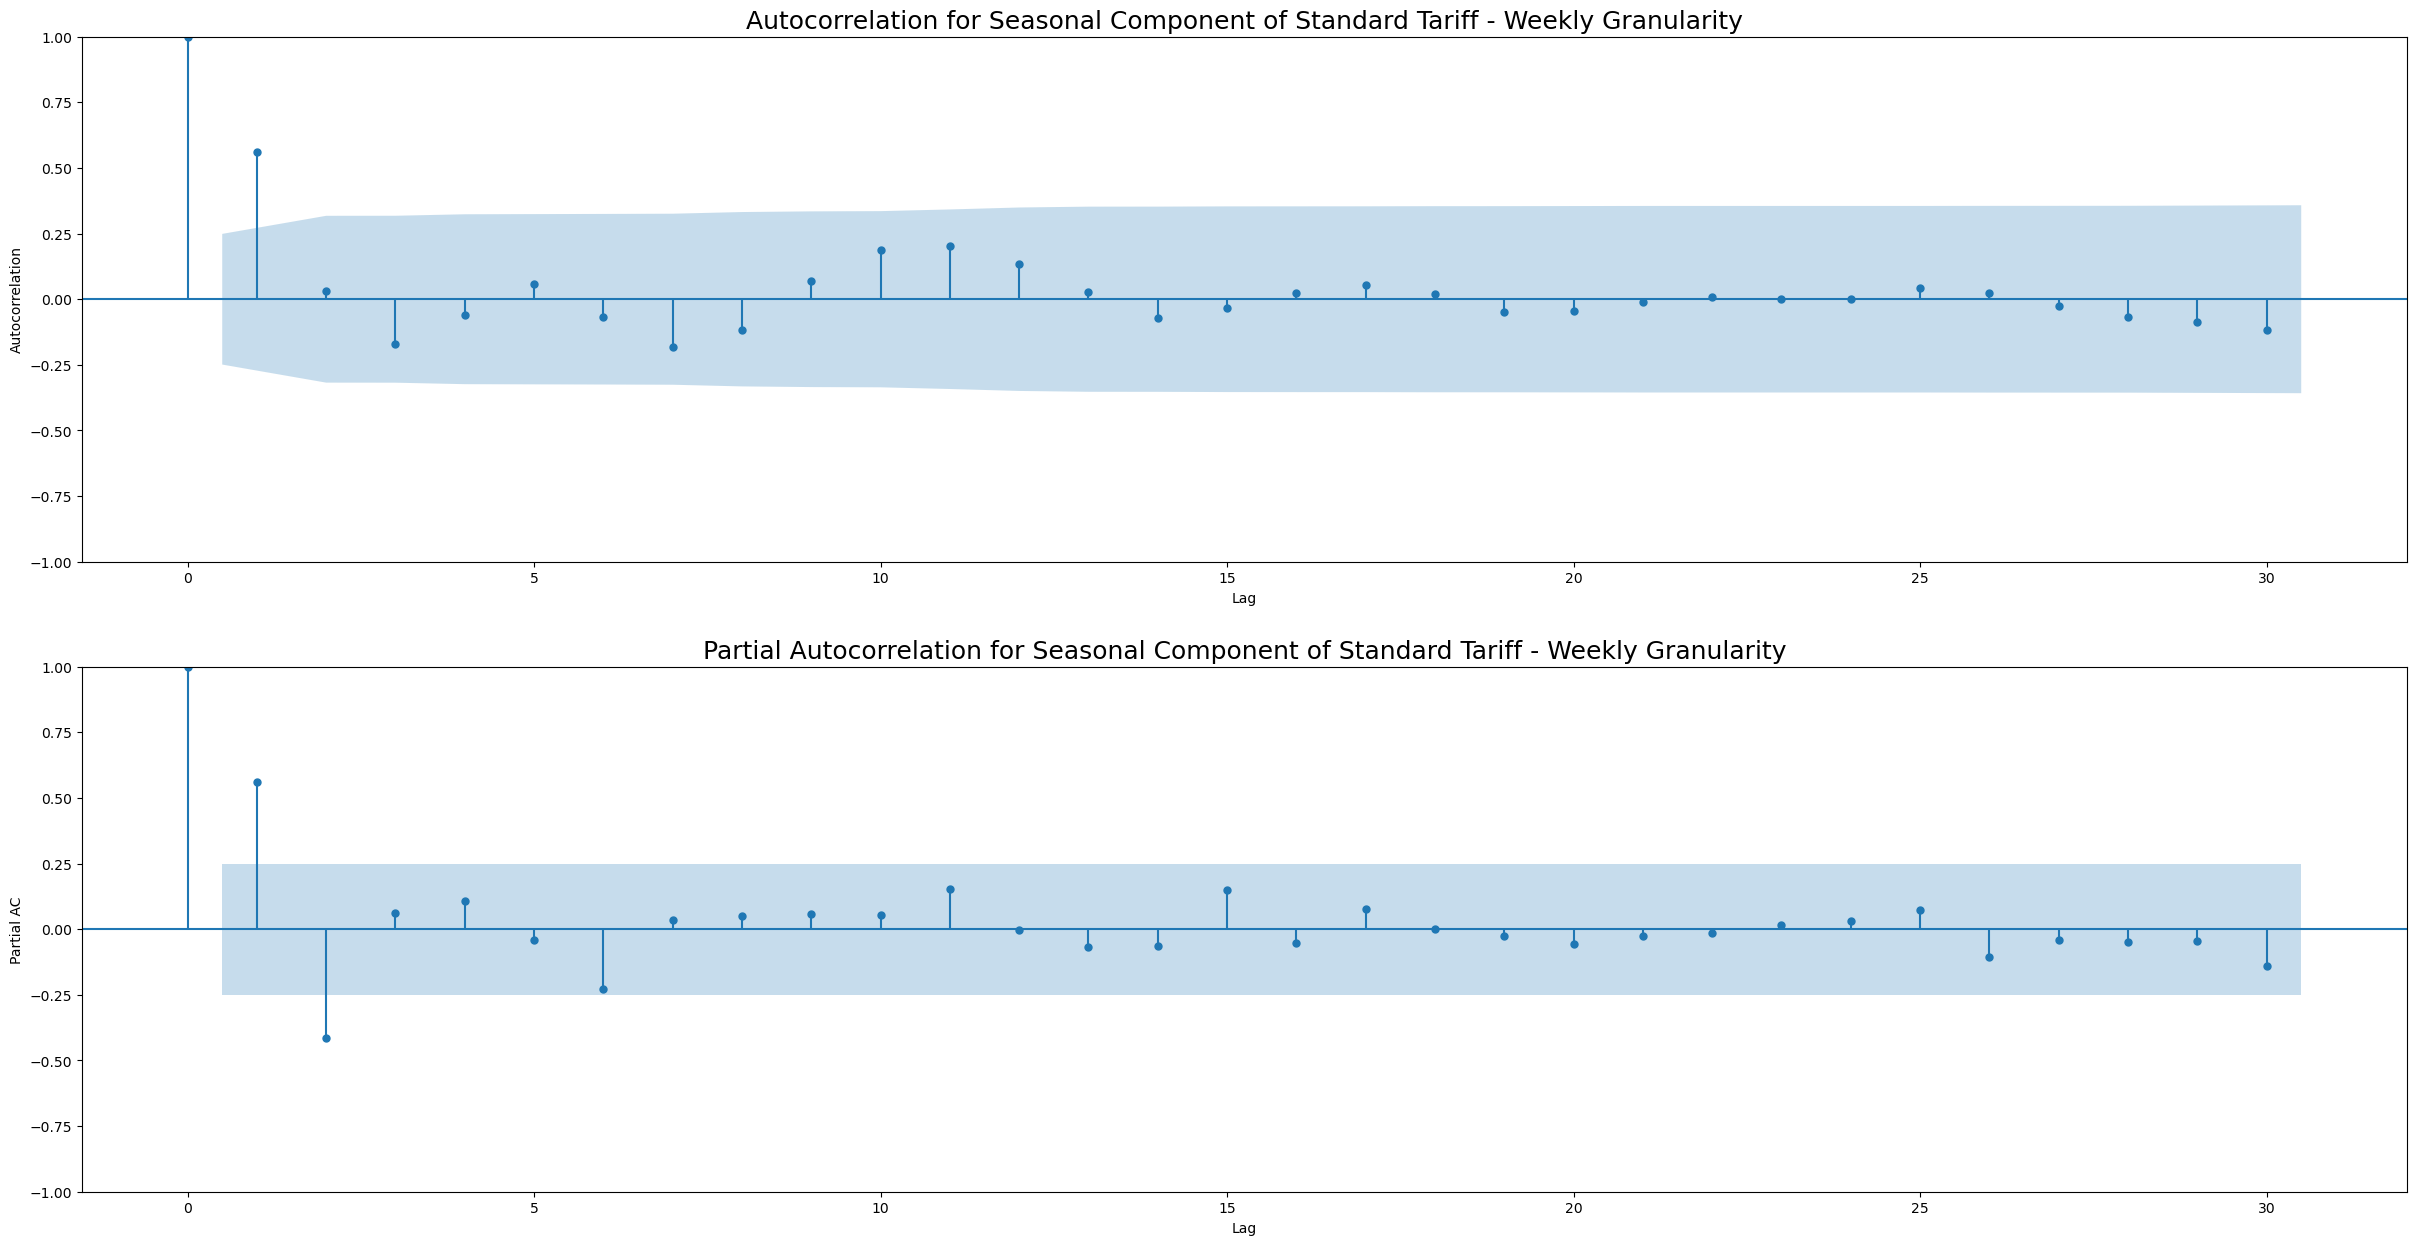

In [7]:
plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(wks_df["Std"].diff(52).dropna(), lags=30, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Seasonal Component of Standard Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(wks_df["Std"].diff(52).dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Seasonal Component of Standard Tariff - Weekly Granularity', fontsize = 18)
plt.show()

In [8]:
Std_test = wks_df['Std'].tail(round(0.2*wks_df["Std"].count()))
Std_train = wks_df['Std'].loc[wks_df.index < Std_test.index[0]]

In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_Std = SARIMAX(Std_train, order=([1,5], 1, [1,5]), seasonal_order = (1,1,2,51), trend="n") #why 51 better?
SARIMA_Std = SARIMA_Std.fit()

SARIMA_Std.summary()

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                          Std   No. Observations:                   91
Model:             SARIMAX([1, 5], 1, [1, 5])x(1, 1, 2, 51)   Log Likelihood                  79.108
Date:                                      Wed, 02 Nov 2022   AIC                           -142.216
Time:                                              21:23:24   BIC                           -128.908
Sample:                                          01-01-2012   HQIC                          -137.441
                                               - 09-22-2013                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3929      0.314     -1.253      0.210      -1.007       0.222
ar.L5          0.3363      0.300      1.121      0.262      -0.252       0.924
ma.L1          0.7431      0.240      3.100      0.002       0.273       1.213
ma.L5         -0.1601      0.374     -0.428      0.669      -0.894       0.573
ar.S.L51      -0.0326      4.364     -0.007      0.994      -8.586       8.521
ma.S.L51      -0.0619      4.325     -0.014      0.989      -8.540       8.416
ma.S.L102     -0.0025      0.410     -0.006      0.995      -0.805       0.800
sigma2         0.0010      0.002      0.601      0.548      -0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 7.20
Prob(Q):                              0.50   Prob(JB):                         0.03
Heteroskedasticity (H):               0.10   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.42e+18. Standard errors may be unstable.
"""

In [73]:
Std_pred_train = SARIMA_Std.predict(Std_train.index[0], end=Std_train.index[len(Std_train)-1]).shift(-1).dropna()
Std_pred_test = SARIMA_Std.predict(Std_test.index[0], end=Std_test.index[len(Std_test)-1]).shift(-1).dropna()

In [74]:
fig = go.Figure()
fig.add_trace(go.Line(x=Std_train.index, y=Std_train, mode='lines', name="Train"))
fig.add_trace(go.Line(x=Std_test.index, y=Std_test, mode='lines', name="Test"))
fig.add_trace(go.Line(x=Std_test.index, y=Std_pred_test, mode='lines', name="Test Predictions"))
fig.add_trace(go.Line(x=Std_train.index, y=Std_pred_train, mode='lines', name="Train Predictions"))

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [75]:
mean_absolute_percentage_error(Std_test.head(-1),Std_pred_test)

0.046180861542840665

In [59]:
mean_absolute_percentage_error(Std_train.head(-1),Std_pred_train)

0.023034771937766343

---

### Variable Tariff

In [77]:
ToU_test = wks_df['ToU'].tail(round(0.2*wks_df["ToU"].count()))
ToU_train = wks_df['ToU'].loc[wks_df.index < ToU_test.index[0]]

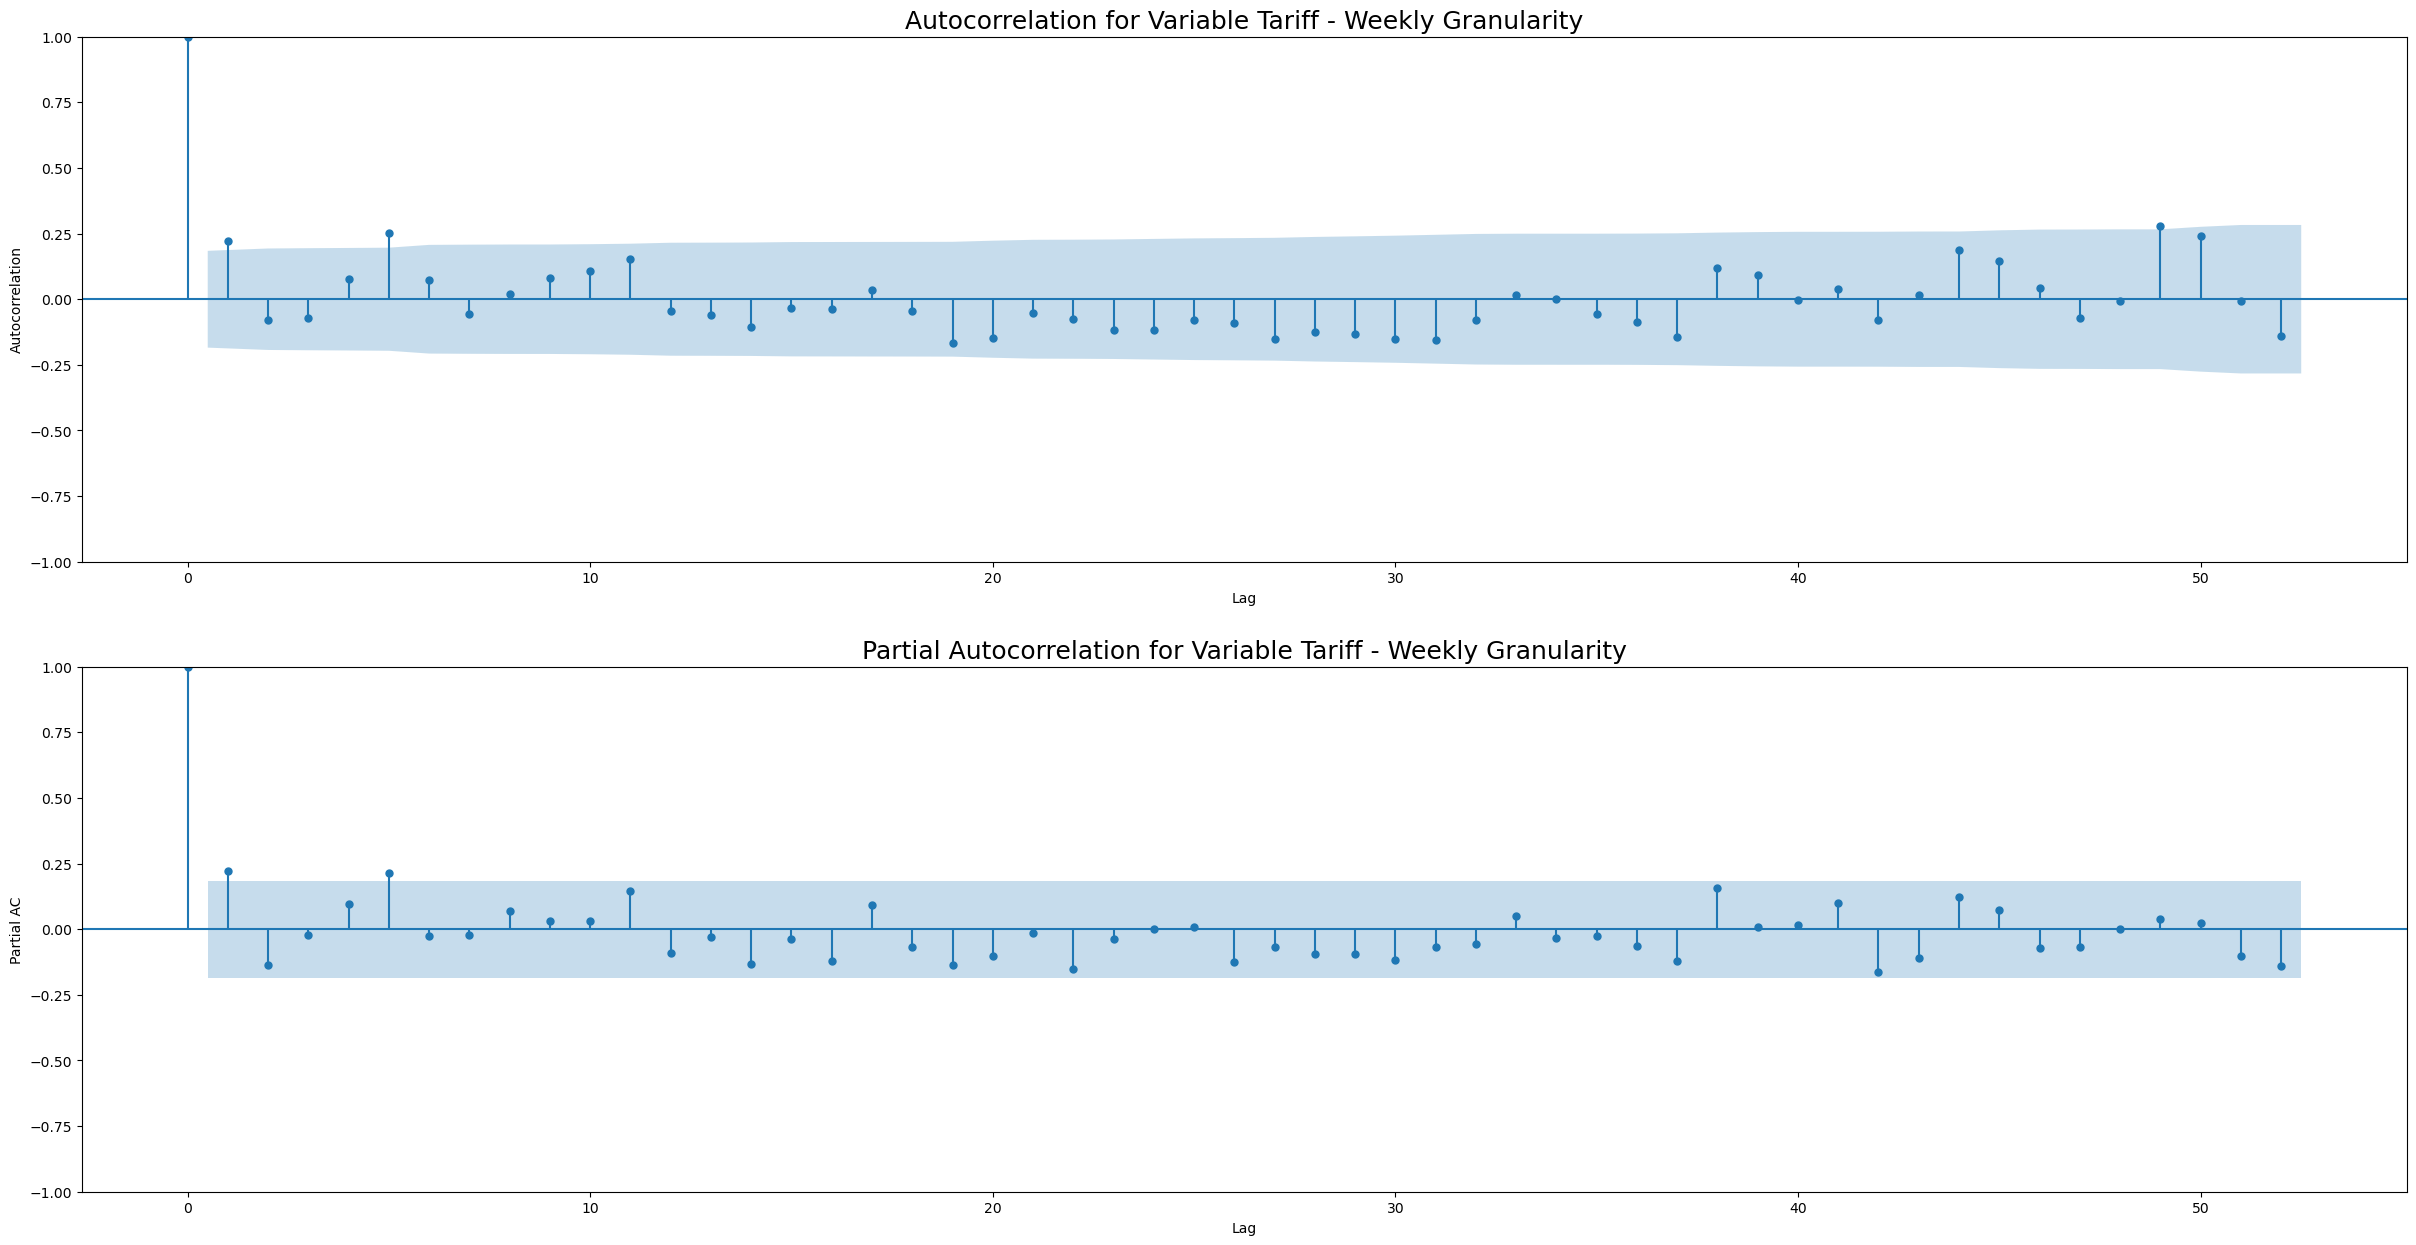

In [78]:
plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(wks_df["Std"].diff(1).dropna(), lags=52, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Variable Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(wks_df["Std"].diff(1).dropna(), lags=52, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Variable Tariff - Weekly Granularity', fontsize = 18)
plt.show()

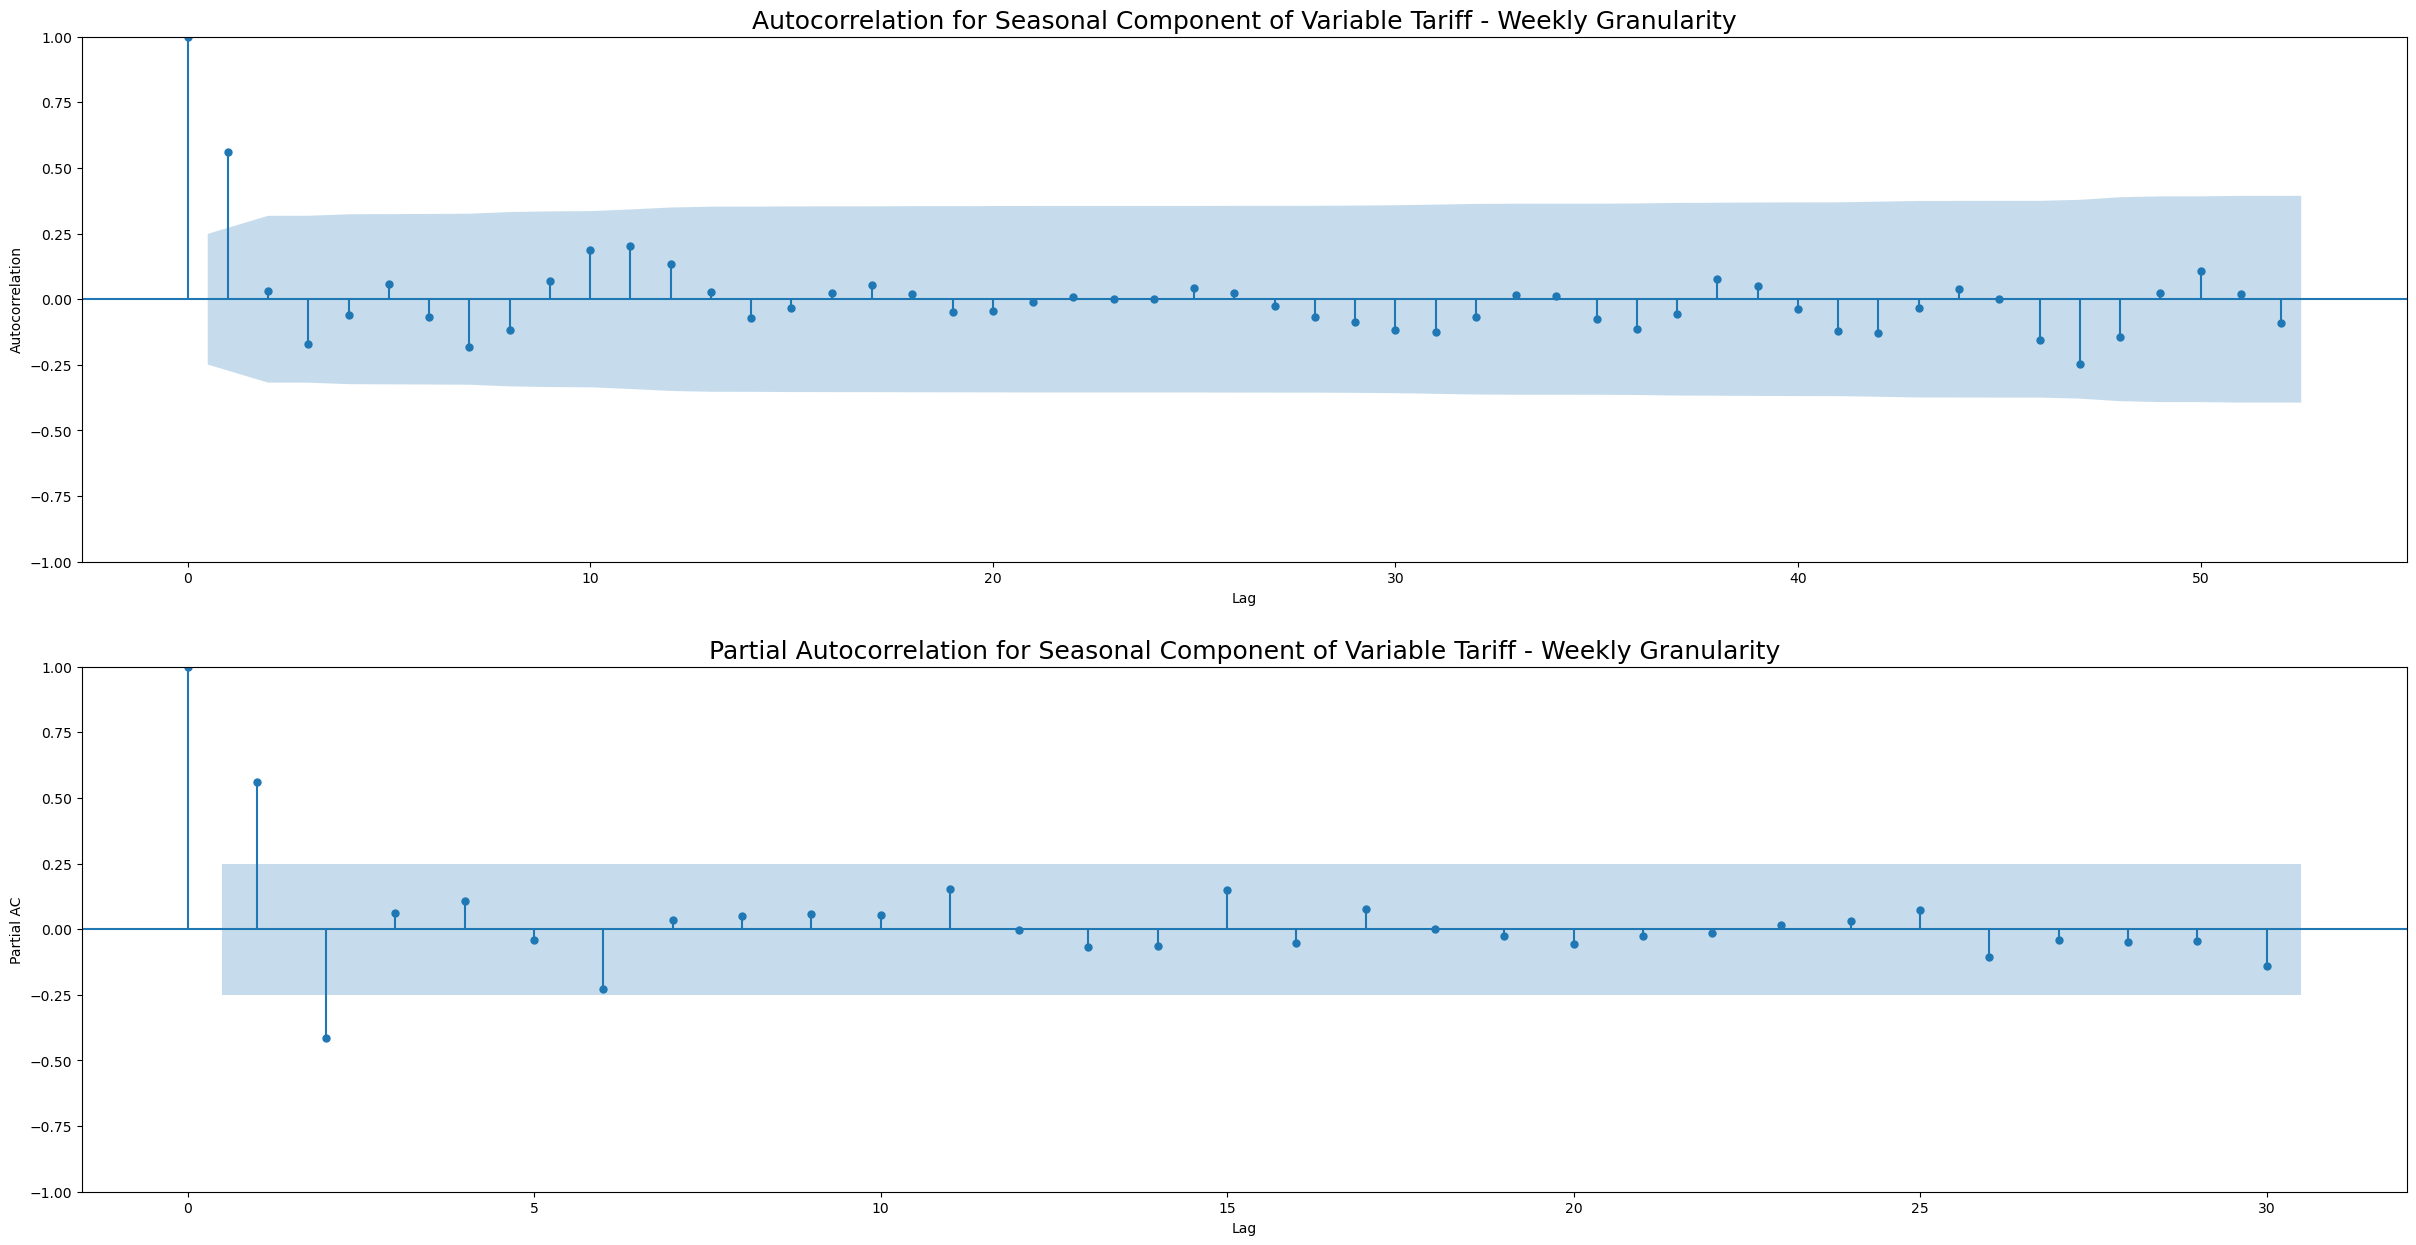

In [79]:
plt.subplots(2, 1, figsize = (30, 15))

plt.subplot(2,1,1)
# put the acf plot on the current axis
plot_acf(wks_df["Std"].diff(52).dropna(), lags=52, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation for Seasonal Component of Variable Tariff - Weekly Granularity', fontsize = 18)

plt.subplot(2,1,2)
plot_pacf(wks_df["Std"].diff(52).dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.title('Partial Autocorrelation for Seasonal Component of Variable Tariff - Weekly Granularity', fontsize = 18)
plt.show()

In [119]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMA_ToU = SARIMAX(ToU_train, order=(1, 1, 1), seasonal_order = (1,1,0,52))
SARIMA_ToU = SARIMA_ToU.fit()

SARIMA_ToU.summary()

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 ToU   No. Observations:                   91
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 52)   Log Likelihood                  78.003
Date:                             Wed, 02 Nov 2022   AIC                           -148.007
Time:                                     21:40:18   BIC                           -141.456
Sample:                                 01-01-2012   HQIC                          -145.676
                                      - 09-22-2013                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5938      0.207      2.863      0.004       0.187       1.000
ma.L1         -0.9763      0.533     -1.831      0.067      -2.022       0.069
ar.S.L52       0.0021   3709.847   5.72e-07      1.000   -7271.164    7271.168
sigma2         0.0009      0.015      0.064      0.949      -0.028       0.030
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):                 8.34
Prob(Q):                              0.38   Prob(JB):                         0.02
Heteroskedasticity (H):               0.06   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
ToU_pred = SARIMA_ToU.predict(start=wks_df.index[0], end = wks_df.index[wks_df.shape[0]-1])

ToU_pred_train = SARIMA_ToU.predict(ToU_train.index[0], end=ToU_train.index[len(ToU_train)-1]).shift(-1).dropna()
ToU_pred_test = SARIMA_ToU.predict(ToU_test.index[0], end=ToU_test.index[len(ToU_test)-1]).shift(-1).dropna()

In [121]:
fig = go.Figure()
fig.add_trace(go.Line(x=ToU_train.index, y=ToU_train, mode='lines', name="Train"))
fig.add_trace(go.Line(x=ToU_test.index, y=ToU_test, mode='lines', name="Test"))
fig.add_trace(go.Line(x=ToU_test.index, y=ToU_pred_test, mode='lines', name="Test Predictions"))
fig.add_trace(go.Line(x=ToU_train.index, y=ToU_pred_train, mode='lines', name="Train Predictions"))
fig.show()

c:\Users\triha\anaconda3\envs\timeseries\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [113]:
mean_absolute_percentage_error(ToU_test.head(-1),ToU_pred_test)

0.07341577371538809

In [115]:
mean_absolute_percentage_error(ToU_train.head(-1),ToU_pred_train)

0.02319939322652043